## Customer Churn Prediction

<u>Description</u>: Customer churn prediction refers to the process of using data analysis and machine learning techniques to forecast or predict when customers are likely to stop using a product or service and leave a company, often referred to as "churn." Customer churn is a significant concern for businesses across various industries, as retaining existing customers is typically more cost-effective than acquiring new ones.

<u>Objective</u>: Develop a machine learning model to predict customer churn based on historical customer data. You 
will follow a typical machine learning project pipeline, from data preprocessing to model deployment.
------------------------------------------------------------------------------------------------------------------

Importing required modules

In [345]:
#Linear algebra and processing 
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report, plot_roc_curve
from sklearn.feature_selection import SelectKBest, mutual_info_classif

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from torch.utils.data import random_split

import time
import os
import pickle
import warnings

Setting enviornment 

In [69]:
class Environment:
    def __init__(self, random_seed):
        self.random_seed = random_seed
        self.random_state = None

    def set_environment(self):
        np.random.seed(self.random_seed)
        torch.manual_seed(self.random_seed)
        self.random_state = np.random.RandomState(self.random_seed)
        warnings.filterwarnings("ignore")

env = Environment(42)
env.set_environment()

General functions

In [70]:
#saving data
def save_object(obj, file_path, file_name):
    """
    Save an object to a specified file using pickle.

    Parameters:
        obj: The object to be saved.
        file_path (str): The directory where the file will be saved.
        file_name (str): The name of the file to save.

    Returns:
        str: A message indicating if the object was saved successfully.
    """
    # Ensure the directory exists
    if not os.path.exists(file_path):
        os.makedirs(file_path)

    file_path = os.path.join(file_path, file_name)

    try:
        with open(file_path, "wb") as file:
            pickle.dump(obj, file)
        return f"Object saved successfully at: {file_path}"
    except Exception as e:
        return f"Failed to save object: {str(e)}"
    
#loading saved data
def load_object(file_path, file_name):
    """
    Load an object from a specified file using pickle.

    Parameters:
        file_path (str): The directory where the file is located.
        file_name (str): The name of the file to load.

    Returns:
        obj: The loaded object.
    """
    file_path = os.path.join(file_path, file_name)

    try:
        with open(file_path, "rb") as file:
            obj = pickle.load(file)
        return obj
    except Exception as e:
        raise ValueError(f"Failed to load object: {str(e)}")

Directory variables

In [71]:
#Directory paths
data_dir = r"C:\Users\91738\OneDrive\Desktop\SunbaseData\inputs"
output_data_dir = r"C:\Users\91738\OneDrive\Desktop\SunbaseData\outputs"
models_dir = r"C:\Users\91738\OneDrive\Desktop\SunbaseData\models"

Loading data

In [72]:
def ensure_directory(directory_path):
    """
    Ensure that a directory exists; if not, create it.

    Parameters:
        directory_path (str): The path of the directory to ensure.

    Raises:
        OSError: If the directory creation fails.
    """
    try:
        if not os.path.exists(directory_path):
            os.makedirs(directory_path)
    except OSError as e:
        raise OSError(f"Failed to create directory: {directory_path}") from e

In [73]:
# Ensure output_data_dir and models_dir exist
ensure_directory(output_data_dir)
ensure_directory(models_dir)

In [74]:
def load_data(data_dir: str, file_name: str) -> pd.DataFrame:
    """
    Load data from a CSV file and parse date columns.

    Parameters:
        data_dir (str): The directory where the data file is located.
        file_name (str): The name of the CSV file to load.

    Returns:
        pd.DataFrame: The loaded dataset.

    Raises:
        FileNotFoundError: If the file is not found.
        pd.errors.ParserError: If there is an error in parsing the CSV file.
    """
    file_path = os.path.join(data_dir, file_name)
    try:
        return pd.read_excel(file_path)
    except FileNotFoundError as e:
        raise FileNotFoundError(f"File not found: {file_path}") from e
    except pd.errors.ParserError as e:
        raise pd.errors.ParserError(f"Error parsing CSV file: {file_path}") from e

In [75]:
# Load data from a CSV file
data = load_data(data_dir,"customer_churn_large_dataset.xlsx")

Data Inspection 

In [76]:
data.head()

,CustomerID,Name,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
0,1.0,Customer_1,63.0,Male,Los Angeles,17.0,73.36,236.0,0.0
1,2.0,Customer_2,62.0,Female,New York,1.0,48.76,172.0,0.0
2,3.0,Customer_3,24.0,Female,Los Angeles,5.0,85.47,460.0,0.0
3,4.0,Customer_4,36.0,Female,Miami,3.0,97.94,297.0,1.0
4,5.0,Customer_5,46.0,Female,Miami,19.0,58.14,266.0,0.0


Data summary statistics

In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   CustomerID                  100000 non-null  float64
 1   Name                        100000 non-null  object 
 2   Age                         100000 non-null  float64
 3   Gender                      100000 non-null  object 
 4   Location                    100000 non-null  object 
 5   Subscription_Length_Months  100000 non-null  float64
 6   Monthly_Bill                100000 non-null  float64
 7   Total_Usage_GB              100000 non-null  float64
 8   Churn                       100000 non-null  float64
dtypes: float64(6), object(3)
memory usage: 6.9+ MB


In [78]:
data.describe()

,CustomerID,Age,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,50000.500000,44.027020,12.490100,65.053197,274.393650,0.497790
std,28867.657797,15.280283,6.926461,20.230696,130.463063,0.499998
min,1.000000,18.000000,1.000000,30.000000,50.000000,0.000000
25%,25000.750000,31.000000,6.000000,47.540000,161.000000,0.000000
50%,50000.500000,44.000000,12.000000,65.010000,274.000000,0.000000
75%,75000.250000,57.000000,19.000000,82.640000,387.000000,1.000000
max,100000.000000,70.000000,24.000000,100.000000,500.000000,1.000000


**Data preprocessing**

- Type Conversion 

In [79]:
def change_data_type(dataset, column_name, target_data_type):
    """
    Change the data type of a column in a Pandas DataFrame.

    Parameters:
        dataset (pd.DataFrame): The DataFrame in which to change the data type.
        column_name (str): The name of the column for which to change the data type.
        target_data_type (type): The target data type to which the column should be converted.

    Returns:
        None

    Raises:
        ValueError: If the specified column does not exist in the dataset.
    """
    try:
        dataset[column_name] = dataset[column_name].astype(target_data_type)
        print(f"Data type of column '{column_name}' changed to {target_data_type.__name__}.")
        return dataset
    except KeyError as e:
        raise ValueError(f"Column not found: {column_name}") from e

In [80]:
#Customer ID columns should be categorical not float
data = change_data_type(data,"CustomerID",str)

Data type of column 'CustomerID' changed to str.


In [81]:
#Churn columns should be categorical not float
data = change_data_type(data,"Churn",int)

Data type of column 'Churn' changed to int.


In [82]:
#Churn columns should be categorical not float
data = change_data_type(data,"Age",int)

Data type of column 'Age' changed to int.


- Duplicate records

In [83]:
def remove_duplicates(dataset):
    """
    Remove duplicates from a Pandas DataFrame.

    Parameters:
        dataset (pd.DataFrame): The DataFrame from which duplicates will be removed.

    Returns:
        pd.DataFrame or str: The modified DataFrame with duplicates removed, or a message
                            indicating no duplicates were found.

    Raises:
        ValueError: If the dataset is not a Pandas DataFrame.
    """
    if not isinstance(dataset, pd.DataFrame):
        raise ValueError("Input dataset is not a Pandas DataFrame.")

    dup_count = dataset.duplicated().sum()
    if dup_count == 0:
        return "No duplicate records"
    else:
        dataset.drop_duplicates(inplace=True)
        return "Duplicate records dropped"

In [84]:
remove_duplicates(data)

'No duplicate records'

- Null values processing 

In [85]:
def null_assessment(dataset):
    """
    Perform a null value assessment on a Pandas DataFrame.

    Parameters:
        dataset (pd.DataFrame): The DataFrame to assess for null values.

    Returns:
        str: A message indicating if null values are present or if processing is required.
    """
    null_count = dataset.isnull().sum().sum()
    if null_count == 0:
        return "No null values"
    else:
        return "Processing required"

In [86]:
null_assessment(data)

'No null values'

- Dropping redundant columns

In [87]:
def calculate_uniqueness_ratio(dataset):
    """
    Calculate the uniqueness ratio for each column in the dataset.

    Parameters:
    dataset (pd.DataFrame): The dataset to calculate uniqueness ratios for.

    Returns:
    dict: A dictionary where keys are column names and values are uniqueness ratios.
    """
    # Select object-type columns
    object_columns = dataset.select_dtypes(include='object').columns

    # Calculate uniqueness ratios
    uniqueness_ratios = {column: len(dataset[column].unique()) / len(dataset)
                         for column in object_columns}

    return uniqueness_ratios

def display_uniqueness_ratios(uniqueness_ratios):
    """
    Display the uniqueness ratios.

    Parameters:
    uniqueness_ratios (dict): A dictionary containing column names and uniqueness ratios.
    """
    print("Uniqueness ratios:\n")
    for column_name, ratio in uniqueness_ratios.items():
        print(f"{column_name}: {ratio}")

In [88]:
uniqueness_ratios = calculate_uniqueness_ratio(data)
display_uniqueness_ratios(uniqueness_ratios)

Uniqueness ratios:

CustomerID: 1.0
Name: 1.0
Gender: 2e-05
Location: 5e-05


In [89]:
"""
As observed, the 'Name' column exhibits a high uniqueness ratio, 
indicating no variation and no correlation. Therefore, it is appropriate to drop these columns.
"""
def drop_columns(dataset, columns=None):
    """
    Drop specified column(s) from a Pandas DataFrame.

    Parameters:
        dataset (pd.DataFrame): The DataFrame from which to drop the column(s).
        columns (str or list of str, optional): The column(s) to drop.

    Returns:
        str: A message indicating if the column(s) were dropped successfully.

    Raises:
        ValueError: If the specified column(s) do not exist in the dataset.
    """
    if columns is None:
        return "No columns specified to drop"

    if isinstance(columns, str):
        columns = [columns]

    try:
        dataset.drop(columns=columns, inplace=True)
        return f"Column(s) '{', '.join(columns)}' dropped successfully"
    except KeyError as e:
        raise ValueError(f"Column(s) not found: {', '.join(columns)}") from e

In [90]:
drop_columns(data,["Name","CustomerID"])

"Column(s) 'Name, CustomerID' dropped successfully"

- Outlier analysis and removal

In [91]:
def plot_box_for_numeric_columns(data, target_column="Churn"):
    """
    Plot boxplots for numeric columns (excluding the target column) in a DataFrame.

    Parameters:
        data (pd.DataFrame): The DataFrame for which to plot boxplots.
        target_column (str): The target column to exclude from plotting (default: "Churn").

    Returns:
        None
    """
    # Select numeric columns excluding the target column
    numeric_columns = data.select_dtypes(include=[float, int]).drop(columns=[target_column]).columns

    # Determine the number of plots needed
    num_plots = len(numeric_columns)

    # Set up subplots
    fig, axes = plt.subplots(1, num_plots, figsize=(13, 4))

    # Plot boxplots for each numeric column
    for i, col in enumerate(numeric_columns):
        axes[i].boxplot(data[col])
        axes[i].set_title(col)
        axes[i].set_ylabel('Value')

    plt.tight_layout()
    plt.show()

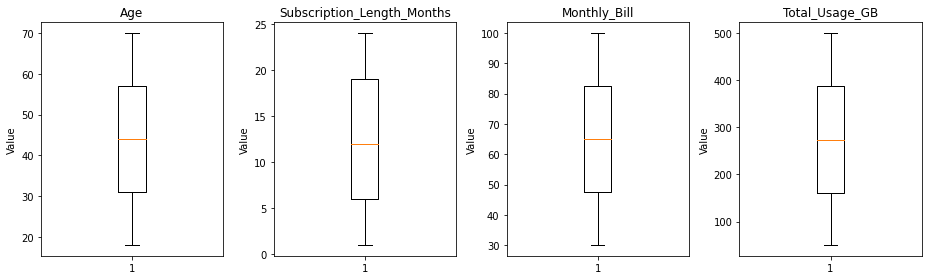

In [92]:
plot_box_for_numeric_columns(data)

In [93]:
def detect_outliers(column):
    """
    Detect outliers in a numerical column using the IQR method.

    Parameters:
    column (pd.Series): A numerical column.

    Returns:
    pd.Series: A boolean series indicating outliers.
    """
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((column < lower_bound) | (column > upper_bound)).sum()

def calculate_outlier_ratio(dataset):
    """
    Calculate the outlier ratio for each numerical column in the dataset using the IQR method.

    Parameters:
    dataset (pd.DataFrame): The dataset.

    Returns:
    dict: A dictionary where keys are column names and values are outlier ratios.
    """
    numerical_columns = dataset.select_dtypes(include='float').columns
    outlier_ratios = {}

    for column in numerical_columns:
        outliers = detect_outliers(dataset[column])
        outlier_ratio = outliers/len(dataset)
        outlier_ratios[column] = outlier_ratio

    return outlier_ratios

def display_outlier_ratios(outlier_ratios):
    """
    Display the outlier ratios.

    Parameters:
    outlier_ratios (dict): A dictionary containing column names and outlier ratios.
    """
    print("Outlier ratios:\n")
    for column_name, ratio in outlier_ratios.items():
        ratio = ratio
        print(f"{column_name}: {ratio}")

In [94]:
outlier_ratios = calculate_outlier_ratio(data) 
display_outlier_ratios(outlier_ratios)

Outlier ratios:

Subscription_Length_Months: 0.0
Monthly_Bill: 0.0
Total_Usage_GB: 0.0


In [95]:
#No need to process outliers

**Feature Engineering**

- Scaling data

In [96]:
def kde_plots_for_numeric_columns(data,super_title):
    """
    Plot KDE plots for numeric columns in a DataFrame.

    Parameters:
        data (pd.DataFrame): The DataFrame for which to plot KDE plots.

    Returns:
        None
    """
    # Select numeric columns
    numeric_columns = data.select_dtypes(include=[float]).columns

    # Determine the number of plots needed
    num_plots = len(numeric_columns)

    # Set up subplots
    fig, axes = plt.subplots(1, num_plots, figsize=(13, 4))

    # Plot KDE plots for each numeric column
    for i, col in enumerate(numeric_columns):
        sns.kdeplot(data[col], ax=axes[i], shade=True, color='blue')
        axes[i].set_title(f'KDE Plot for {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Density')

    plt.suptitle(super_title, fontsize=20)
    plt.tight_layout()
    plt.show()

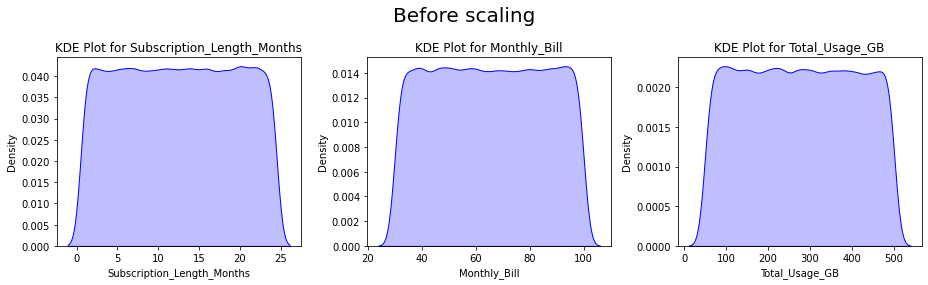

In [97]:
kde_plots_for_numeric_columns(data,"Before scaling")

In [98]:
def scale_data(data):
    """

    Parameters:
    data (pd.DataFrame): The dataset to be scaled.

    Returns:
    pd.DataFrame: The scaled dataset.
    """
    columns = data.select_dtypes(include='float').columns
    
    scalers = [('StandardScaler', StandardScaler()),
               ('MinMaxScaler', MinMaxScaler()),
               ('RobustScaler', RobustScaler()),
               ('PowerTransformer', PowerTransformer(method='yeo-johnson'))
              ]
    
    scaler_pipeline = Pipeline(scalers)
    data[columns] = scaler_pipeline.fit_transform(data[columns])
    return data

In [99]:
scaled_data = scale_data(data)

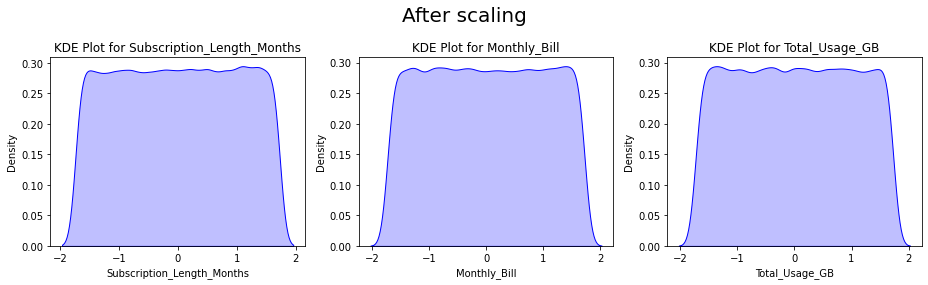

In [100]:
kde_plots_for_numeric_columns(scaled_data,"After scaling")

- Encoding data

In [101]:
def label_encode_categorical(dataset):
    """
    Label encode object-type columns in a Pandas DataFrame.

    Parameters:
        dataset (pd.DataFrame): The DataFrame to label encode.

    Returns:
        pd.DataFrame: A new DataFrame with object columns label encoded.

    Raises:
        TypeError: If the input is not a Pandas DataFrame.
    """
    if not isinstance(dataset, pd.DataFrame):
        raise TypeError("Input is not a Pandas DataFrame.")

    # Select columns with object data type
    object_columns = dataset.select_dtypes(include=['object']).columns

    if len(object_columns) == 0:
        print("No object columns found to label encode.")
        return dataset.copy()

    # Copy the DataFrame to avoid modifying the original
    encoded_dataset = dataset.copy()

    # Apply label encoding to object columns
    label_encoder = LabelEncoder()
    for column in object_columns:
        encoded_dataset[column] = label_encoder.fit_transform(encoded_dataset[column])

    print("Object columns label encoded.")
    return encoded_dataset

In [102]:
data = label_encode_categorical(scaled_data)

Object columns label encoded.


In [103]:
#processed data view
data.head()

,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
0,63,1,2,0.652504,0.410694,-0.291984,0
1,62,0,4,-1.663214,-0.805341,-0.783986,0
2,24,0,2,-1.081882,1.009198,1.420174,0
3,36,0,3,-1.372390,1.625432,0.175752,1
4,46,0,3,0.940040,-0.341626,-0.061787,0


- Saving processed data

In [104]:
save_object(data,output_data_dir,"processed_data.pkl")        

'Object saved successfully at: C:\\Users\\91738\\OneDrive\\Desktop\\SunbaseData\\outputs\\processed_data.pkl'

In [105]:
data = load_object(output_data_dir,"processed_data.pkl")
data.head()

,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
0,63,1,2,0.652504,0.410694,-0.291984,0
1,62,0,4,-1.663214,-0.805341,-0.783986,0
2,24,0,2,-1.081882,1.009198,1.420174,0
3,36,0,3,-1.372390,1.625432,0.175752,1
4,46,0,3,0.940040,-0.341626,-0.061787,0


**Model Building**

- Features and labels

In [106]:
#features and labels
X, y = data.drop(columns=["Churn"]), data["Churn"]
print(f"Features:{X.shape}\nLabels:{y.shape}")

Features:(100000, 6)
Labels:(100000,)


- Splitting data

In [107]:
def split_data(features,labels,random_state=env.random_state):
    """
    Split features and labels into training and testing sets.

    Parameters:
        features (array-like): The features to be split.
        labels (array-like): The labels to be split.
        random_state (int, RandomState instance, or None, optional): 
            Random state to use for random sampling (default: None).

    Returns:
        tuple: A tuple containing (X_train, X_test, y_train, y_test).
    """
    X,x,Y,y = train_test_split(features, labels, test_size=0.3, random_state=random_state, stratify=labels)
    print(f"X_train shape:{X.shape} | y_train shape:{Y.shape}\nX_test shape:{x.shape} | y_test shape:{y.shape}")
    return X,x,Y,y

In [108]:
X_train, X_test, y_train, y_test = split_data(X,y)

X_train shape:(70000, 6) | y_train shape:(70000,)
X_test shape:(30000, 6) | y_test shape:(30000,)


- Model selection 

ML algorithms

In [109]:
models = [
    ("KNeighborsClassifier", KNeighborsClassifier()),  # K-Nearest Neighbors
    ("DecisionTreeClassifier", DecisionTreeClassifier()),  # Decision Tree
    ("LogisticRegression", LogisticRegression()),  # Logistic Regression
    ("RandomForestClassifier", RandomForestClassifier()),  # Random Forest
    ("GradientBoostingClassifier", GradientBoostingClassifier()),  # Gradient Boosting
    ("VotingClassifier", VotingClassifier(estimators=[
        ("knn", KNeighborsClassifier()),
        ("dt", DecisionTreeClassifier()),
        ("lr", LogisticRegression()),
        ("rf", RandomForestClassifier()),
        ("gr", GradientBoostingClassifier())
    ], voting='soft'))  # Soft voting ensemble
]

In [110]:
def calculate_classification_metrics(model, X_test, y_test):
    """
    Calculate classification metrics for a given model.

    Parameters:
    model: A trained classification model.
    X_test (array-like): Feature matrix of the test set.
    y_test (array-like): True labels of the test set.

    Returns:
    dict: A dictionary containing the classification metrics.
    """
    y_preds = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_preds)
    precision = precision_score(y_test, y_preds)
    recall = recall_score(y_test, y_preds)
    f1 = f1_score(y_test, y_preds)
    
    metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
    }
    
    return metrics

def calculate_metrics_for_models(models, X_train, y_train, X_test, y_test):
    """
    Calculate classification metrics for a list of models.

    Parameters:
    models (list): A list of tuples containing model names and instances.
    X_test (array-like): Feature matrix of the test set.
    y_test (array-like): True labels of the test set.

    Returns:
    list: A list of dictionaries containing the classification metrics for each model.
    """
    model_metrics = []

    for model_name, model in models:
        if isinstance(model, str):
            continue 
            
        # Measure the time taken to fit the model
        start_time = time.time()
        model.fit(X_train, y_train)
        end_time = time.time()
        fit_time = end_time - start_time
        
        metrics = calculate_classification_metrics(model, X_test, y_test)
        print(f"--{model_name}--")
        print(f"Fit time: {fit_time:.4f} seconds\n")
        
        model_metrics.append({
            "Model_name": model_name,
            "Model": model,
            **metrics
        })
    return model_metrics

In [111]:
model_summary = calculate_metrics_for_models(models, X_train, y_train, X_test, y_test)

--KNeighborsClassifier--
Fit time: 0.0748 seconds

--DecisionTreeClassifier--
Fit time: 0.4929 seconds

--LogisticRegression--
Fit time: 0.2378 seconds

--RandomForestClassifier--
Fit time: 9.2764 seconds

--GradientBoostingClassifier--
Fit time: 4.8301 seconds

--VotingClassifier--
Fit time: 13.5237 seconds



In [112]:
def summary(model_summary):
    """
    Display a summary of model performance and sort by F1 Score and Recall.

    Parameters:
    model_summary (list): A list of dictionaries containing model performance metrics.

    Returns:
    None
    """
    # Create a DataFrame from the model summary
    model_summary_df = pd.DataFrame(model_summary).drop(columns=["Model"])
    
    # Print the model performance summary
    print("Model Performance Summary:")
    sorted_summary = model_summary_df.sort_values(["F1 Score", "Recall"], ascending=False)
    print(sorted_summary)

In [113]:
summary(model_summary)

Model Performance Summary:
                   Model_name  Accuracy  Precision    Recall  F1 Score
1      DecisionTreeClassifier  0.501667   0.499460  0.495313  0.497378
5            VotingClassifier  0.500533   0.498319  0.496183  0.497249
0        KNeighborsClassifier  0.500167   0.497937  0.492902  0.495407
3      RandomForestClassifier  0.489267   0.486241  0.459087  0.472274
4  GradientBoostingClassifier  0.496767   0.493045  0.386902  0.433572
2          LogisticRegression  0.497667   0.493434  0.342172  0.404112


In [114]:
def get_model(model_to_get, summary=model_summary):
    """
    Retrieve a model from the model summary based on its name.

    Parameters:
    model_to_get (str): The name of the model to retrieve.
    summary (list, optional): The model summary list to search for the model.

    Returns:
    model: The requested model instance.
    """
    if summary is None:
        raise ValueError("Model summary (summary) should be provided.")

    if not isinstance(summary, list):
        raise TypeError("Model summary (summary) should be a list.")

    for stat in summary:
        if stat["Model_name"].lower() == model_to_get.lower():
            return stat["Model"]

    raise KeyError("Model not found in the model summary.")  

In [115]:
def add_model(model, model_name, X_train, y_train, X_test, y_test, add_in=None,):
    """
    Add a model and its metrics to the model summary.

    Parameters:
    model: A trained classification model.
    model_name (str): The name of the model.
    add_in (list, optional): The model summary list to append the model metrics to.

    Returns:
    None
    """
    if add_in is None:
        raise ValueError("Model summary (add_in) should be provided.")

    if not isinstance(add_in, list):
        raise TypeError("Model summary (add_in) should be a list.")
        
    new_model = [(model_name,model)]
    metrics = calculate_metrics_for_models(new_model, X_train, y_train, X_test, y_test)
    add_in.extend(metrics)
    return add_in

Neural Network

In [162]:
#converting to tenor dataset
def tensor_dataset(X, y):
    """
    Create a PyTorch tensor dataset from input features and labels.

    Parameters:
        X (array-like): Input features.
        y (array-like): Labels.

    Returns:
        torch.utils.data.TensorDataset: Tensor dataset containing X and y.
    """
    X_tensor = torch.from_numpy(np.array(X))
    y_tensor = torch.from_numpy(np.array(y)).reshape(-1, 1)
    dataset = TensorDataset(X_tensor, y_tensor)
    return dataset

In [165]:
tensor_data = tensor_dataset(X,y)
tensor_data[:3]

(tensor([[63.0000,  1.0000,  2.0000,  0.6525,  0.4107, -0.2920],
         [62.0000,  0.0000,  4.0000, -1.6632, -0.8053, -0.7840],
         [24.0000,  0.0000,  2.0000, -1.0819,  1.0092,  1.4202]],
        dtype=torch.float64),
 tensor([[0],
         [0],
         [0]], dtype=torch.int32))

In [175]:
#Splitting data
def split_dataset(data, train_size, val_size, test_size):
    """
    Split a dataset into training, validation, and test sets using random_split.

    Parameters:
        data (torch.utils.data.Dataset): The dataset to be split.
        train_size (int): Size of the training set.
        val_size (int): Size of the validation set.
        test_size (int): Size of the test set.

    Returns:
        tuple: A tuple containing train, validation, and test datasets.
    """
    total_size = len(data)
    assert train_size + val_size + test_size == total_size, "Sizes don't add up to total size of the dataset."

    train_ds, val_ds, test_ds = random_split(data, [train_size, val_size, test_size])
    return train_ds, val_ds, test_ds

In [180]:
train_ds, val_ds, test_ds = split_dataset(tensor_data, 80000, 15000, 5000)
print(f"train_length:{len(train_ds)} | validation_length:{len(val_ds)} | test_length:{len(test_ds)}")

train_length:80000 | validation_length:15000 | test_length:5000


In [181]:
#creating batches of data
def dataloader(dataset, batch_size, shuffle=True):
    """
    Create a PyTorch DataLoader for the given dataset.

    Parameters:
        dataset (torch.utils.data.Dataset): The dataset to be loaded.
        batch_size (int): Batch size for loading data.

    Returns:
        torch.utils.data.DataLoader: DataLoader for the specified dataset.
    """
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return loader

In [182]:
train_dl = dataloader(train_ds, 5000, shuffle=True)
val_dl = dataloader(val_ds, 5000, shuffle=False)
test_dl = dataloader(test_ds, 5000, shuffle=False)

In [183]:
for xb,yb in train_dl:
    print(xb,yb)
    break

tensor([[44.0000,  1.0000,  0.0000, -0.2126, -0.6877,  1.5344],
        [33.0000,  1.0000,  3.0000,  1.0837, -1.6948,  0.6041],
        [61.0000,  0.0000,  3.0000,  1.3707, -1.4575,  1.6333],
        ...,
        [68.0000,  0.0000,  1.0000,  1.0837, -0.7688, -0.0771],
        [21.0000,  0.0000,  0.0000,  0.2205, -0.4533, -1.4004],
        [18.0000,  0.0000,  3.0000,  0.9400, -0.6644, -1.4467]],
       dtype=torch.float64) tensor([[0],
        [0],
        [0],
        ...,
        [0],
        [1],
        [1]], dtype=torch.int32)


In [184]:
for batch in train_dl:
    features,labels = batch
    print(features.shape,labels)
    break

torch.Size([5000, 6]) tensor([[1],
        [0],
        [1],
        ...,
        [1],
        [0],
        [1]], dtype=torch.int32)


In [248]:
#Network building 
def accuracy(outputs, actuals):
    """
    Calculate the accuracy of model predictions.

    Parameters:
        outputs (torch.Tensor): Model predictions.
        actuals (torch.Tensor): Actual labels.

    Returns:
        torch.Tensor: Accuracy of the predictions.
    """
    _, preds = torch.max(outputs, dim=1)
    acc = torch.tensor(torch.sum(preds == actuals).item() / len(preds))
    return acc

class LogisticRegression(nn.Module):
    """
    Logistic Regression Model.

    This class represents a logistic regression model for binary classification.

    Methods:
        training_step: Perform a training step.
        validation_step: Perform a validation step.
        validation_epoch_end: Compute validation loss and accuracy at the end of an epoch.
        epoch_end: Print training and validation metrics at the end of an epoch.
        evaluate: Evaluate the model on a validation dataloader.

    """

    def training_step(self, batch):
        """
        Perform a training step.

        Parameters:
            batch (tuple): A tuple containing features and labels.

        Returns:
            torch.Tensor: Loss for the current training step.
        """
        features, labels = batch
        outputs = self(features)
        loss = F.cross_entropy(outputs, labels.squeeze().long())
        return loss

    def validation_step(self, batch):
        """
        Perform a validation step.

        Parameters:
            batch (tuple): A tuple containing features and labels.

        Returns:
            dict: Validation loss and accuracy.
        """
        features, labels = batch
        outputs = self(features)
        loss = F.cross_entropy(outputs, labels.squeeze().long())
        acc = accuracy(outputs, labels.squeeze().long())
        return {"val loss": loss.detach(), "val acc": acc}

    def validation_epoch_end(self, outputs):
        """
        Compute validation loss and accuracy at the end of an epoch.

        Parameters:
            outputs (list): List of dictionaries containing validation loss and accuracy.

        Returns:
            dict: Validation loss and accuracy for the epoch.
        """
        batch_loss = [x["val loss"] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x["val acc"] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {"val loss": epoch_loss.item(), "val acc": epoch_acc.item()}

    def epoch_end(self, epoch_num, results, fit_one_cycle=False):
        """
        Print training and validation metrics at the end of an epoch.

        Parameters:
            epoch_num (int): Epoch number.
            results (dict): Training and validation metrics for the epoch.
            fit_one_cycle (bool, optional): Whether using a one-cycle learning rate policy.

        """
        if epoch_num%10==0:
            if fit_one_cycle:
                print("Epoch [{}], last_lr: {:.5f}, train loss: {:.4f}, val loss: {:.4f}, val acc: {:.4f}".format(
                    epoch_num, results['lrs'][-1], results['train loss'], results['val loss'], results['val acc']))
            else:
                print("Epoch[{}] -> TRAIN LOSS : {:.4f} | VALIDATION LOSS : {:.4f} | VALIDATION ACC : {:.4f}".format(
                    epoch_num, results["train loss"], results["val loss"], results["val acc"]))

    @torch.no_grad()
    def evaluate(self, val_dl):
        """
        Evaluate the model on a validation dataloader.

        Parameters:
            val_dl (torch.utils.data.DataLoader): Dataloader for validation dataset.

        Returns:
            dict: Validation loss and accuracy.
        """
        self.eval()
        outputs = [self.validation_step(batch) for batch in val_dl]
        return self.validation_epoch_end(outputs)

In [249]:
class NetworkArchitecture(LogisticRegression):
    """
    Logistic Regression Model.

    This class represents a logistic regression model for binary classification.

    Args:
        input_dim (int): Number of input features.
        output_dim (int): Number of output classes.

    Attributes:
        model (torch.nn.Sequential): The sequential model comprising linear, batch normalization, and activation layers.

    Methods:
        forward(x): Forward pass through the model.

    """

    def __init__(self, input_dim, output_dim):
        """
        Initialize the Logistic_Regression model.

        Args:
            input_dim (int): Number of input features.
            output_dim (int): Number of output classes.

        """
        super(NetworkArchitecture, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 3),
            nn.BatchNorm1d(3),
            nn.ReLU(),
            nn.Linear(3, output_dim)
        )

    def forward(self, x):
        """
        Perform a forward pass through the model.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after the forward pass.

        """
        x = x.float()
        outputs = torch.sigmoid(self.model(x))
        return outputs

In [250]:
#input and output dimensions
input_dim = len(X.columns)
output_dim = len(np.unique(y))

In [251]:
#models
model_f = NetworkArchitecture(input_dim, output_dim) # normal fit method
model_foc = NetworkArchitecture(input_dim, output_dim) # fit one cycle

<u>fit method</u>

In [252]:
def fit(epoch_num, lr, model, train_dl, val_dl, optim_func):
    """
    Train the model using the specified optimizer and training parameters.

    Parameters:
        epoch_num (int): Number of epochs for training.
        lr (float): Learning rate for the optimizer.
        model (nn.Module): PyTorch model to train.
        train_dl (DataLoader): Dataloader for training data.
        val_dl (DataLoader): Dataloader for validation data.
        optim_func: Optimizer function (e.g., torch.optim.Adam).

    Returns:
        list: Training history containing metrics for each epoch.
    """
    optimizer = optim_func(model.parameters(), lr)
    history = []

    for epoch in range(epoch_num):
        train_losses = []

        for batch in train_dl:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        results = model.evaluate(val_dl)
        results["train loss"] = torch.stack(train_losses).mean()
        model.epoch_end(epoch, results)
        history.append(results)

    return history

In [245]:
model_f.evaluate(val_dl)

{'val loss': 0.6941781044006348, 'val acc': 0.4983333349227905}

In [253]:
#defining paramters
num_epochs = 101
opt_func = torch.optim.Adam
lr = 0.001

In [254]:
%%time
history = fit(num_epochs, lr, model_f, train_dl, val_dl, opt_func)

Epoch[0] -> TRAIN LOSS : 0.7002 | VALIDATION LOSS : 0.6991 | VALIDATION ACC : 0.4941
Epoch[10] -> TRAIN LOSS : 0.6933 | VALIDATION LOSS : 0.6935 | VALIDATION ACC : 0.4941
Epoch[20] -> TRAIN LOSS : 0.6932 | VALIDATION LOSS : 0.6933 | VALIDATION ACC : 0.4996
Epoch[30] -> TRAIN LOSS : 0.6931 | VALIDATION LOSS : 0.6933 | VALIDATION ACC : 0.5014
Epoch[40] -> TRAIN LOSS : 0.6931 | VALIDATION LOSS : 0.6932 | VALIDATION ACC : 0.5013
Epoch[50] -> TRAIN LOSS : 0.6931 | VALIDATION LOSS : 0.6932 | VALIDATION ACC : 0.5039
Epoch[60] -> TRAIN LOSS : 0.6931 | VALIDATION LOSS : 0.6932 | VALIDATION ACC : 0.5069
Epoch[70] -> TRAIN LOSS : 0.6931 | VALIDATION LOSS : 0.6932 | VALIDATION ACC : 0.5075
Epoch[80] -> TRAIN LOSS : 0.6931 | VALIDATION LOSS : 0.6932 | VALIDATION ACC : 0.5109
Epoch[90] -> TRAIN LOSS : 0.6931 | VALIDATION LOSS : 0.6931 | VALIDATION ACC : 0.5067


In [289]:
def plot_accuracies(history):
    """
    Plot validation accuracies over epochs.

    Parameters:
        history (list): List of dictionaries containing validation metrics.

    Returns:
        None
    """
    plt.figure(figsize=(10,5))
    accuracies = [x['val acc'] for x in history]
    plt.plot(accuracies, '-')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. No. of Epochs')
    plt.show()

In [303]:
def plot_losses(history):
    """
    Plot training and validation losses over epochs.

    Parameters:
        history (list): List of dictionaries containing training and validation metrics.

    Returns:
        None
    """
    train_losses = [x.get('train loss').item() for x in history]
    val_losses = [x['val loss'].item() if isinstance(x['val loss'], torch.Tensor) else x['val loss'] for x in history]
    
    plt.figure(figsize=(10,5))
    plt.plot(train_losses, '-b', label='Training Loss')
    plt.plot(val_losses, '-r', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss vs. No. of Epochs')
    plt.show()

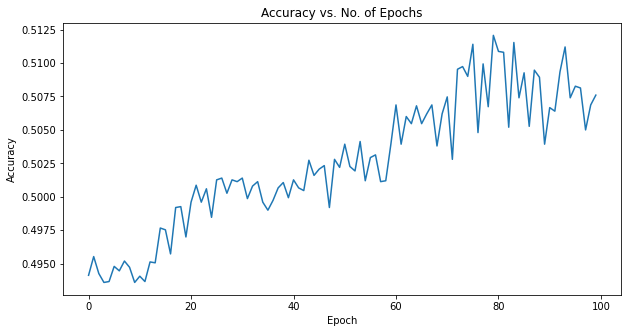

In [297]:
plot_accuracies(history)

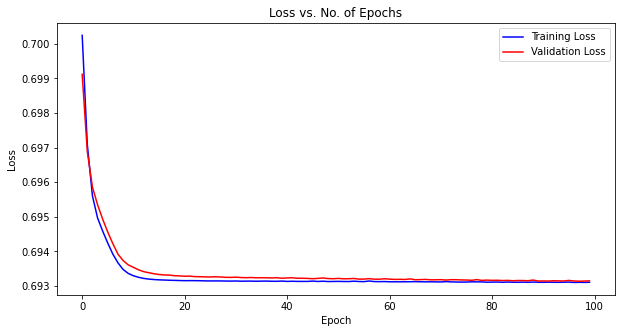

In [298]:
plot_losses(history)

<u>fit one cycle</u>

In [292]:
def get_lr(optimizer):
    """
    Get the learning rate from the optimizer.

    Parameters:
        optimizer (torch.optim.Optimizer): Optimizer used for training.

    Returns:
        float: Learning rate.
    """
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    """
    Train the model using the One Cycle Policy.

    Parameters:
        epochs (int): Number of epochs to train.
        max_lr (float): Maximum learning rate.
        model: The model to train.
        train_loader (torch.utils.data.DataLoader): DataLoader for the training set.
        val_loader (torch.utils.data.DataLoader): DataLoader for the validation set.
        weight_decay (float, optional): Weight decay (L2 regularization). Default is 0.
        grad_clip (float, optional): Gradient clipping value. Default is None.
        opt_func (torch.optim.Optimizer, optional): Optimizer function. Default is torch.optim.SGD.

    Returns:
        list: List of dictionaries containing training and validation metrics for each epoch.
    """
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)

    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs): 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            lrs.append(get_lr(optimizer))
            sched.step()
        result = model.evaluate(val_loader)
        result['train loss'] = torch.stack(train_losses).mean()
        result['lrs'] = lrs
        model.epoch_end(epoch, result, fit_one_cycle=True)
        history.append(result)
    return history

In [293]:
history_foc = [model_foc.evaluate(val_dl)]
history_foc

[{'val loss': 0.6931398510932922, 'val acc': 0.5051999688148499}]

In [294]:
epochs = 101
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [295]:
%%time
history_foc += fit_one_cycle(epochs, max_lr, model_foc,
                         train_dl, val_dl, 
                         grad_clip = grad_clip, 
                         weight_decay = weight_decay, 
                         opt_func = opt_func)

Epoch [0], last_lr: 0.00042, train loss: 0.6931, val loss: 0.6931, val acc: 0.5053
Epoch [10], last_lr: 0.00318, train loss: 0.6931, val loss: 0.6931, val acc: 0.5050
Epoch [20], last_lr: 0.00793, train loss: 0.6931, val loss: 0.6932, val acc: 0.5027
Epoch [30], last_lr: 0.01000, train loss: 0.6931, val loss: 0.6931, val acc: 0.5073
Epoch [40], last_lr: 0.00945, train loss: 0.6931, val loss: 0.6932, val acc: 0.5022
Epoch [50], last_lr: 0.00803, train loss: 0.6931, val loss: 0.6931, val acc: 0.5043
Epoch [60], last_lr: 0.00603, train loss: 0.6931, val loss: 0.6931, val acc: 0.5051
Epoch [70], last_lr: 0.00382, train loss: 0.6931, val loss: 0.6932, val acc: 0.5021
Epoch [80], last_lr: 0.00185, train loss: 0.6931, val loss: 0.6932, val acc: 0.5013
Epoch [90], last_lr: 0.00049, train loss: 0.6931, val loss: 0.6932, val acc: 0.5051
Epoch [100], last_lr: 0.00000, train loss: 0.6931, val loss: 0.6932, val acc: 0.5039
CPU times: total: 3min 30s
Wall time: 2min 7s


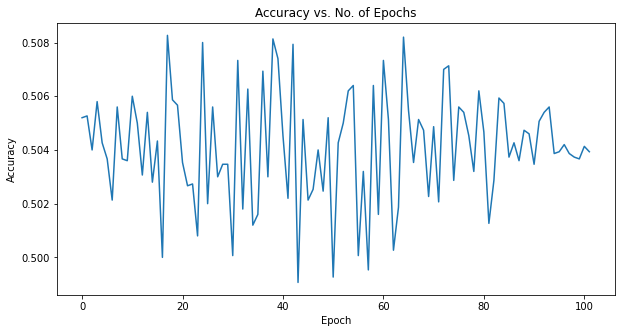

In [299]:
plot_accuracies(history_foc)

In [307]:
def plot_lrs(history):
    """
    Plot the learning rates for each batch.

    Parameters:
        history (list): List of dictionaries containing training and validation metrics for each epoch.

    Returns:
        None
    """
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')
    plt.show()

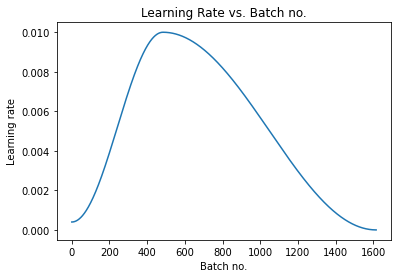

In [308]:
plot_lrs(history_foc)

In [309]:
#Saving the w&b
folder_path = models_dir
torch.save(model_f.state_dict(), folder_path + 'model_weights.pth')

**Model Optimization**

In [116]:
summary(model_summary) #We will optimize the top 2 models and compare

Model Performance Summary:
                   Model_name  Accuracy  Precision    Recall  F1 Score
1      DecisionTreeClassifier  0.501667   0.499460  0.495313  0.497378
5            VotingClassifier  0.500533   0.498319  0.496183  0.497249
0        KNeighborsClassifier  0.500167   0.497937  0.492902  0.495407
3      RandomForestClassifier  0.489267   0.486241  0.459087  0.472274
4  GradientBoostingClassifier  0.496767   0.493045  0.386902  0.433572
2          LogisticRegression  0.497667   0.493434  0.342172  0.404112


- Decision Tree

In [117]:
dt_classifier = get_model("decisiontreeclassifier")
dt_classifier

DecisionTreeClassifier()

In [118]:
#Define parameter combination
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [119]:
# Create the grid search using 5-fold cross-validation
grid_search = GridSearchCV(dt_classifier, param_grid, cv=5, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30, 40, 50],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]})

In [120]:
# Print the best hyperparameters found
print("Best Hyperparameters:")
print(grid_search.best_params_)

Best Hyperparameters:
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}


In [121]:
# Use the best model
best_dt_model = grid_search.best_estimator_

In [122]:
#Add model in summary
model_summary = add_model(best_dt_model,"TunedDecisionTreeClassifier",X_train, y_train, X_test, y_test, add_in=model_summary)

--TunedDecisionTreeClassifier--
Fit time: 0.5554 seconds



- Voting classifier

In [132]:
voting_classifier = get_model("votingclassifier")
voting_classifier

VotingClassifier(estimators=[('knn', KNeighborsClassifier()),
                             ('dt', DecisionTreeClassifier()),
                             ('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()),
                             ('gr', GradientBoostingClassifier())],
                 voting='soft')

In [133]:
#Define parameter combination
param_grid = {
    'knn__n_neighbors': [3, 5, 7],
    'knn__weights': ['uniform', 'distance'],
    'dt__max_depth': [None, 10, 20, 30],
    'dt__min_samples_split': [2, 5, 10],
    'lr__C': [0.1, 1.0, 10.0],
    'lr__penalty': ['l1', 'l2'],
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 10, 20, 30],
    'gr__n_estimators': [50, 100, 200],
    'gr__learning_rate': [0.05, 0.1, 0.2]
}

In [134]:
# Create the random search using 5-fold cross-validation
random_search = RandomizedSearchCV(voting_classifier, param_grid,n_iter=20, cv=5, n_jobs=-1)

# Fit the random search to the data
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=VotingClassifier(estimators=[('knn',
                                                           KNeighborsClassifier()),
                                                          ('dt',
                                                           DecisionTreeClassifier()),
                                                          ('lr',
                                                           LogisticRegression()),
                                                          ('rf',
                                                           RandomForestClassifier()),
                                                          ('gr',
                                                           GradientBoostingClassifier())],
                                              voting='soft'),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'dt__max_depth': [None, 10, 20, 30],
                                        

In [135]:
# Use the best model
best_vc_model = random_search.best_estimator_

In [136]:
#Add model in summary
model_summary = add_model(best_vc_model,"TunedVotingClassifier",X_train, y_train, X_test, y_test, add_in=model_summary)

--TunedVotingClassifier--
Fit time: 5.1586 seconds



In [137]:
#Summary view
summary(model_summary) #Even after optimzation, base models have better performance

Model Performance Summary:
                    Model_name  Accuracy  Precision    Recall  F1 Score
1       DecisionTreeClassifier  0.501667   0.499460  0.495313  0.497378
5             VotingClassifier  0.500533   0.498319  0.496183  0.497249
0         KNeighborsClassifier  0.500167   0.497937  0.492902  0.495407
7        TunedVotingClassifier  0.496833   0.494519  0.486340  0.490395
6  TunedDecisionTreeClassifier  0.504867   0.502817  0.478037  0.490114
3       RandomForestClassifier  0.489267   0.486241  0.459087  0.472274
4   GradientBoostingClassifier  0.496767   0.493045  0.386902  0.433572
2           LogisticRegression  0.497667   0.493434  0.342172  0.404112


- Saving models

In [139]:
save_object(model_summary,models_dir,"modelsummary.pkl")

'Object saved successfully at: C:\\Users\\91738\\OneDrive\\Desktop\\SunbaseData\\models\\modelsummary.pkl'

In [140]:
save_object(dt_classifier,models_dir,"final_model.pkl")

'Object saved successfully at: C:\\Users\\91738\\OneDrive\\Desktop\\SunbaseData\\models\\final_model.pkl'

**Feature selection**

In [156]:
dummy_model = load_object(models_dir,"final_model.pkl")
dummy_model

DecisionTreeClassifier()

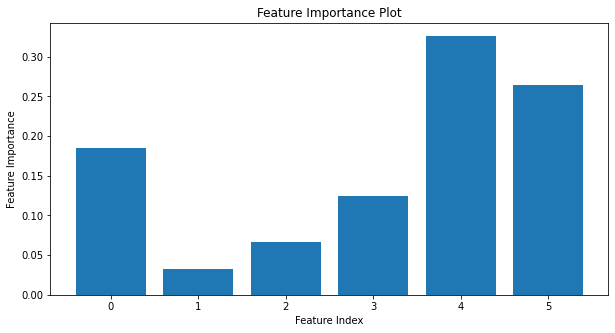

In [157]:
plt.figure(figsize=(10,5))
if hasattr(dummy_model, 'feature_importances_'):
    feature_importance = dummy_model.feature_importances_
    plt.bar(range(len(feature_importance)), feature_importance)
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Importance')
    plt.title('Feature Importance Plot')
    plt.show()

In [158]:
max_components = X.shape[1]
summary = {}  # Dictionary to store all metrics
feature_names = X.columns

for k in range(1, max_components):
    selector = SelectKBest(score_func=mutual_info_classif, k=k)
    X_new_train = selector.fit_transform(X_train, y_train)
    X_new_test = selector.transform(X_test)
    
    # Get the names of the selected features
    selected_feature_names = [feature_names[i] for i in selector.get_support(indices=True)]
    
    # Train the dummy model on the selected features
    dummy_model.fit(X_new_train, y_train)
    
    # Make predictions and calculate evaluation metrics
    y_preds = dummy_model.predict(X_new_test)
    f1 = f1_score(y_test, y_preds)
    recall = recall_score(y_test, y_preds)
    accuracy = accuracy_score(y_test, y_preds)
    precision = precision_score(y_test, y_preds)
    
    # Store the metrics and selected feature names in the summary dictionary
    summary[f"features[{k}]"] = {
        'f1_score': f1,
        'recall_score': recall,
        'accuracy_score': accuracy,
        'precision_score': precision,
        'selected_features': selected_feature_names
    }

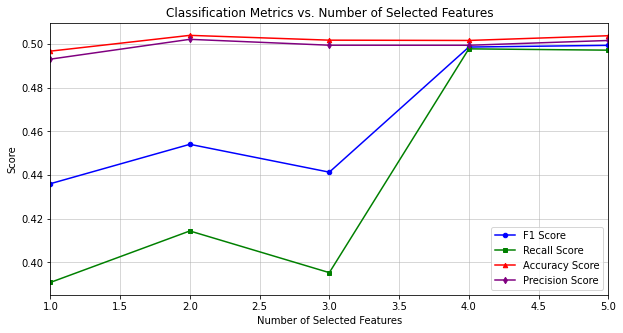

In [159]:
import matplotlib.pyplot as plt

# Assuming 'summary' is the combined summary dictionary

plt.figure(figsize=(10, 5))

# Plot F1 score
plt.plot(range(1, max_components), [score['f1_score'] for k, score in summary.items()], marker="o", ms=4.5, label="F1 Score", color='blue')

# Plot Recall score
plt.plot(range(1, max_components), [score['recall_score'] for k, score in summary.items()], marker="s", ms=4.5, label="Recall Score", color='green')

# Plot Accuracy score
plt.plot(range(1, max_components), [score['accuracy_score'] for k, score in summary.items()], marker="^", ms=4.5, label="Accuracy Score", color='red')

# Plot Precision score
plt.plot(range(1, max_components), [score['precision_score'] for k, score in summary.items()], marker="d", ms=4.5, label="Precision Score", color='purple')

plt.xlabel("Number of Selected Features")
plt.ylabel("Score")
plt.title("Classification Metrics vs. Number of Selected Features")
plt.xlim(1, max_components-1)
plt.grid(linewidth=0.5)
plt.legend()
plt.show()

*Note*: Feature selection is deemed unnecessary as we achieve optimal results without employing this step.

**Model Evaluation and deployment**

1 - Decision tree (best ml classifier)

In [332]:
final_model = load_object(models_dir,"final_model.pkl")
final_model

DecisionTreeClassifier()

In [333]:
#making predictions
y_preds = final_model.predict(X_test)

In [335]:
#metrices
accuracy = accuracy_score(y_test, y_preds)
precision = precision_score(y_test, y_preds)
recall = recall_score(y_test, y_preds)
f1 = f1_score(y_test, y_preds)

print(f"accuracy:{accuracy:.4f} | precision:{precision:.4f}\nrecall:{recall:.4f} | f1 score:{f1:.4f}")

accuracy:0.5017 | precision:0.4995
recall:0.4953 | f1 score:0.4974


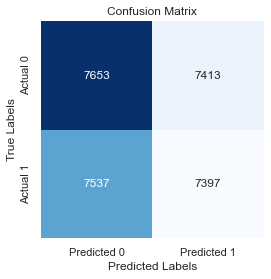

In [340]:
#confusion matrix
conf_matrix = confusion_matrix(y_test, y_preds)

sns.set(font_scale=1)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [347]:
classification_rep = classification_report(y_test, y_preds)
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.51      0.51     15066
           1       0.50      0.50      0.50     14934

    accuracy                           0.50     30000
   macro avg       0.50      0.50      0.50     30000
weighted avg       0.50      0.50      0.50     30000



2 - Neural Network

In [311]:
#Reloading models
nn_model = NetworkArchitecture(input_dim,output_dim)

In [313]:
folder_path = models_dir
model_weights_path = folder_path + 'model_weights.pth'
nn_model.load_state_dict(torch.load(model_weights_path))

<All keys matched successfully>

In [314]:
nn_model

NetworkArchitecture(
  (model): Sequential(
    (0): Linear(in_features=6, out_features=3, bias=True)
    (1): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=3, out_features=2, bias=True)
  )
)

In [318]:
# Set the model to evaluation mode
nn_model.eval()

# Initialize lists to store predictions and labels
predictions = []
true_labels = []

# Disable gradient calculation for inference
with torch.no_grad(): 
    # Iterate through the test dataloader
    for batch in test_dl:
        inputs, targets = batch
        # Get the model predictions
        outputs = nn_model(inputs)
        predictions.append(outputs.argmax(dim=1))
        true_labels.append(targets)

# Concatenate the predictions and true labels
predictions = torch.cat(predictions, dim=0)
true_labels = torch.cat(true_labels, dim=0)

# Convert predictions to float type
predictions = predictions.to(dtype=float)

In [320]:
predictions[:5]

tensor([0., 1., 0., 0., 0.], dtype=torch.float64)

In [321]:
labels[:5]

tensor([[1],
        [0],
        [0],
        [1],
        [1]], dtype=torch.int32)

In [331]:
#Model evaluation 
y_pred_np = predictions.numpy().flatten()
y_true_np = labels.numpy().flatten()

TP = np.sum((y_true_np == 1) & (y_pred_np == 1))
FP = np.sum((y_true_np == 0) & (y_pred_np == 1))
FN = np.sum((y_true_np == 1) & (y_pred_np == 0))
TN = np.sum((y_true_np == 0) & (y_pred_np == 0))
conf_matrix = confusion_matrix(y_true_np, y_pred_np)

print("True Positives (TP):", TP)
print("False Positives (FP):", FP)
print("False Negatives (FN):", FN)
print("True Negatives (TN):", TN)

True Positives (TP): 567
False Positives (FP): 552
False Negatives (FN): 1958
True Negatives (TN): 1923


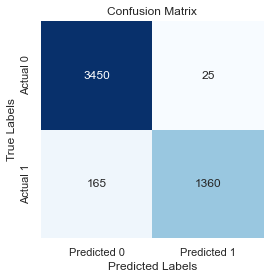

In [160]:
sns.set(font_scale=1)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [329]:
accuracy = accuracy_score(y_true_np, y_pred_np)
precision = precision_score(y_true_np, y_pred_np)
recall = recall_score(y_true_np, y_pred_np)
f1 = f1_score(y_true_np, y_pred_np)

print(f"accuracy:{accuracy:.4f} | precision:{precision:.4f}\nrecall:{recall:.4f} | f1 score:{f1:.4f}")

accuracy:0.4980 | precision:0.5067
recall:0.2246 | f1 score:0.3112


In [330]:
classification_rep = classification_report(y_true_np, y_pred_np)
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.78      0.61      2475
           1       0.51      0.22      0.31      2525

    accuracy                           0.50      5000
   macro avg       0.50      0.50      0.46      5000
weighted avg       0.50      0.50      0.46      5000

